<h1 align='center'> Minumum Daily Temperature Analysis<h1>

<h2 align='right'> Euiyoung Chung <h2>




In [29]:
import warnings
warnings.filterwarnings("ignore")

# data wrangling
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
import seaborn as sns

# tsa
import statsmodels.tsa.api as sm
from statsmodels.tsa.stattools import adfuller

# ml
from sklearn.model_selection import train_test_split

rcParams['figure.figsize'] = 12, 6
rcParams['axes.labelsize'] = 14
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12

plt.style.use('seaborn-whitegrid')
%matplotlib inline

<br>
# Data Import

In [2]:
ls

daily-minimum-temperatures-in-me.xlsx  minimum_daily_temp.ipynb


In [10]:
df = pd.read_excel('daily-minimum-temperatures-in-me.xlsx', header=14)

In [14]:
df = df.drop('Unnamed: 2', axis=1)

In [16]:
df.isnull().sum()

Date          0
Unnamed: 1    0
dtype: int64

In [15]:
df.head()

,Date,Unnamed: 1
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3650 entries, 1981-01-01 to 1990-12-31
Data columns (total 1 columns):
temp    3650 non-null float64
dtypes: float64(1)
memory usage: 57.0 KB


In [20]:
df.columns = ['date', 'temp']
df = df.set_index(['date'])

<br>
# Exploratory Data Analysis

Text(0.5,1,'Minimum Temperature over Time')

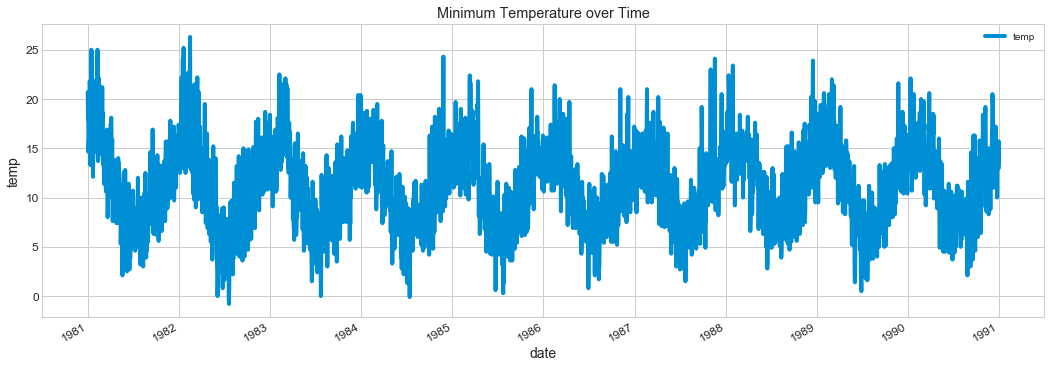

In [34]:
df.plot(figsize=(16,6))
plt.ylabel('temp')
plt.title('Minimum Temperature over Time')

Text(0.5,1,'Minimum Temperature over Time')

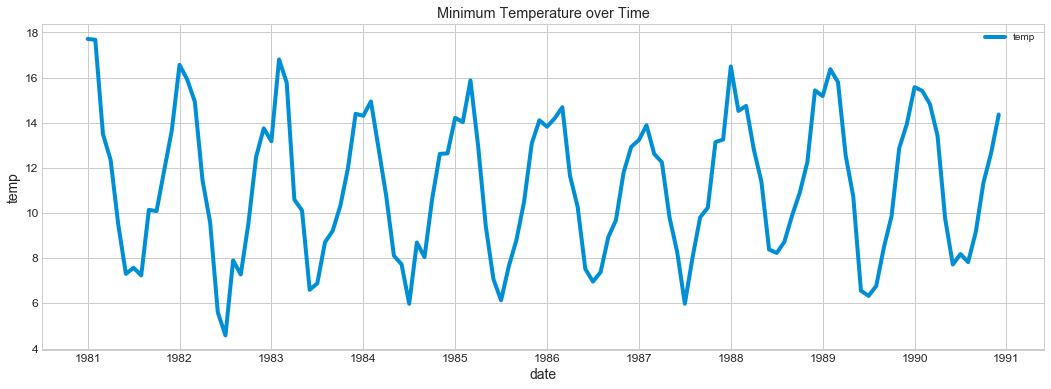

In [38]:
# Downsampling
df_month = df.resample('MS').mean()
df_month.plot(figsize=(16,6))
plt.ylabel('temp')
plt.title('Minimum Temperature over Time')

In [45]:
# Stationary check - non-stationarity detected
ad_test = adfuller(df_month['temp'])
result = pd.Series(ad_test[:4], ['test stat', 'p-val', '# of lags used', '# of observations used'])
result

test stat                  -1.895775
p-val                       0.334051
# of lags used             13.000000
# of observations used    106.000000
dtype: float64

In [48]:
# Differencing for sttionary
df_diff_12 = df_month.diff(12).dropna()

# See the data is stationary now
ad_test = adfuller(df_diff_12['temp'])
result = pd.Series(ad_test[:4], ['test stat', 'p-val', '# of lags used', '# of observations used'])
result

test stat                 -4.766741
p-val                      0.000063
# of lags used            11.000000
# of observations used    96.000000
dtype: float64

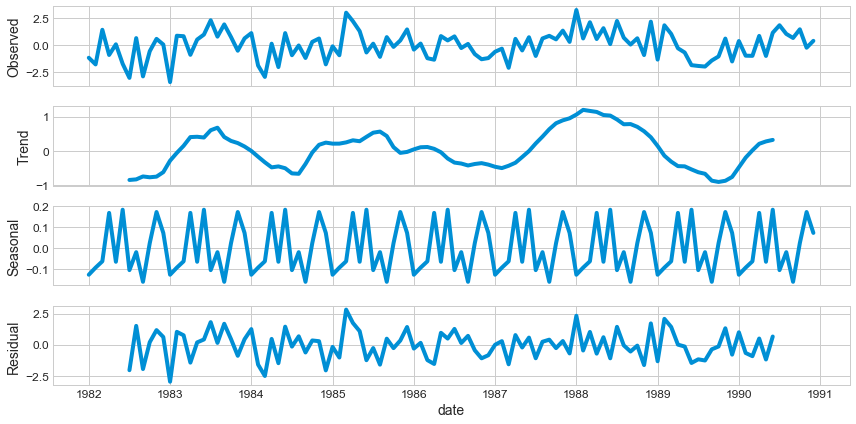

In [50]:
# Decomposition
rcParams['figure.figsize'] = 12, 6
decomposition = sm.seasonal_decompose(df_diff_12, model='additive')
fig = decomposition.plot()
plt.show()

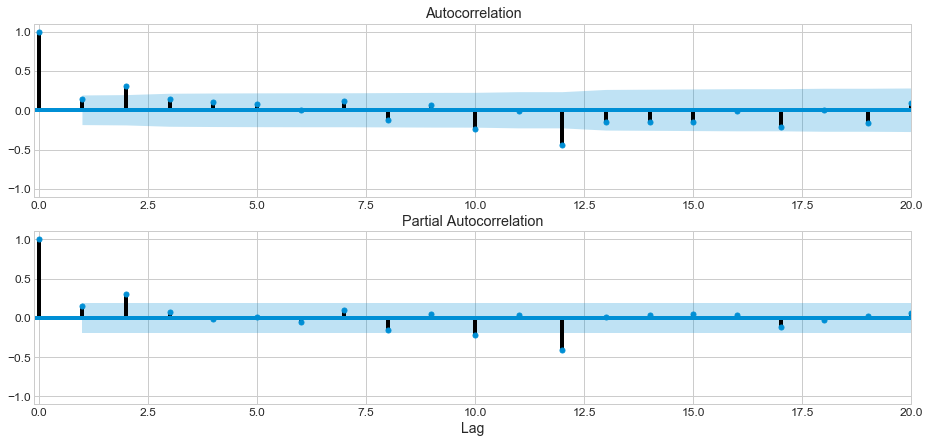

In [178]:
# ACF, PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 7))

sm.graphics.plot_acf(df_diff_12, lags=40, ax=ax1)
sm.graphics.plot_pacf(df_diff_12, lags=40, ax=ax2)

ax1.set_xlim(-0.1,20)
ax1.set_ylim(-1.1,1.1)

ax2.set_xlim(-0.1,20)
ax2.set_ylim(-1.1,1.1)
ax2.set_xlabel("Lag")

plt.show()

## Finindings 

- Careful data transformation using differencing managed to make the time series data stationary.
- I will try to build a SARIMA model with grid-search.

In [203]:
import itertools

# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [204]:
aic = float('inf')

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.SARIMAX(df_month,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            
            if results.aic < aic:
                min_aic_par = param
                min_aic_season_par = param_seasonal
                
            
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:722.915174770098
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:269.420517993594
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:367.8205954238213
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:321.652838660591
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:295.8610286829622
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:275.5329588785435
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:774.7191035446062
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:612.0325181440579
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:359.53120655101026
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:259.57943884280536
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:368.2166563814028
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:370.21517463377506
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:295.9240023935513
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:269.82012432389047
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:413.9938779302693
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:299.4388957511802
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:396.7911592964824
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:365.267958965282
ARIMA(0, 1

In [206]:
mod = sm.SARIMAX(df_month, order=min_aic_par, seasonal_order=min_aic_season_par,
                enforce_stationarity=False, enforce_invertibility=False)

results = mod.fit()

In [207]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                               temp   No. Observations:                  120
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -129.414
Date:                            Sat, 08 Dec 2018   AIC                            268.828
Time:                                    19:12:54   BIC                            282.765
Sample:                                01-01-1981   HQIC                           274.488
                                     - 12-01-1990                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1904      0.167     -1.140      0.254      -0.518       0.137
ma.L1         -0.4649      0.166     -2.803      0.005      -0.790      -0.140
ar.S.L12      -0.2497      0.121     -2.063      0.039      -0.487      -0.012
ma.S.L12      -0.5079      0.142     -3.579      0.000      -0.786      -0.230
sigma2         0.9153      0.129      7.106      0.000       0.663       1.168
===================================================================================
Ljung-Box (Q):                       57.66   Jarque-Bera (JB):                 3.89
Prob(Q):                              0.03   Prob(JB):                         0.14
Heteroskedasticity (H):               0.59   Skew:                             0.47
Prob(H) (two-sided):                  0.15   Kurtosis:                         3.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

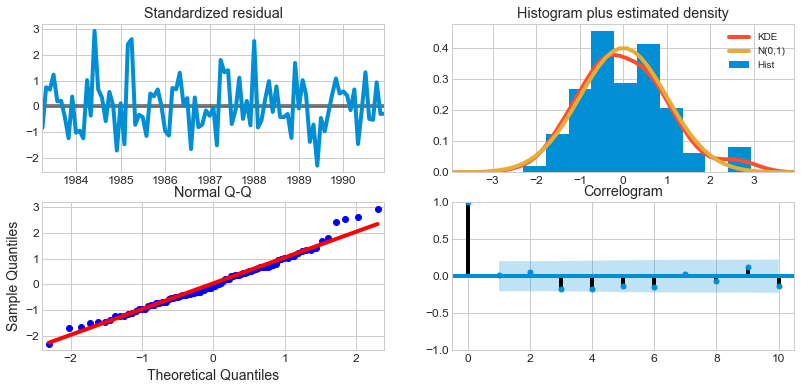

In [208]:
# Goodness-of-fit test
results.plot_diagnostics()
plt.show()

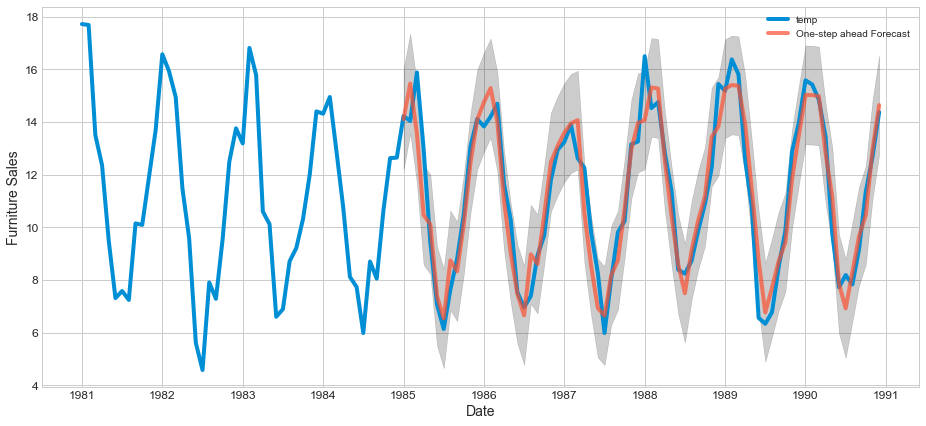

In [209]:
# Predictions
pred = results.get_prediction(start=pd.to_datetime('1985-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = df_month.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

In [230]:
# MSE 
y_forecasted = pred.predicted_mean
y_truth = df_month['1985-01-01':]

# Compute the mean square error
mse = np.sqrt(((y_forecasted - y_truth.squeeze()) ** 2).mean())
print('The Root Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Root Mean Squared Error of our forecasts is 0.95


<br>
## Conclusion:

The final one-step forward predictions are satisfying with 0.95 of RMSE. Considering the fact that I started with unorganized non-stationary time series data, there was a huge improvement in the modeling process.

